# Collaborative Review Task 3 - Fourier Transforms for Option Pricing

In this assignment, you are going to be required to price a European **put** option using the three different techniques in the Fourier Transfrom Notebook. The parameters are as follows:

- Risk-free continuously-compounded interest rate, r, of 10%

- Strike price, K, of $100

- Initial stock price, S0, of $120

- Time to maturity, T, of 2 years

- Stock volatility, σ, of 25%

You may make all the assumptions of the standard Black-Scholes model.

## 1. Initialize the relevant parameters. (5% of total points)

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# share specific information
r = 0.1
S0 = 120
sigma = 0.25

# call option specific information
K = 100
T = 2
k_log = np.log(K)

## 2. Calculate the analytical price for the put option using the closed-form solution. (10% of total points)

In [3]:
# code for the analytical solution for vanilla European put option pricing
d1_stock = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
d2_stock = d1_stock - sigma*np.sqrt(T)

analytic_putprice = K*np.exp(-r*T)*norm.cdf(-d2_stock) - S0*norm.cdf(-d1_stock)
analytic_putprice

2.4693867508857075

## 3. Calculate the estimate for the put price using the characteristic function and technique described in note set 1. 

Use a maximum integral bound of 40 and N=200 rectangles to approximate your integral. (20% of total points)

In [6]:
# Characteristic functions where 1j is used to create the imaginary number i
def c_M1(t):
    return np.exp(1j*t*(np.log(S0)+(r-sigma**2/2)*T) - (sigma**2)*T*(t**2)/2)

def c_M2(t):
    return np.exp(1j*t*sigma**2*T)*c_M1(t)

In [7]:
# Choosing t_max and N
t_max = 40
N = 200

# Calculating delta and constructing t_n
delta_t = t_max/N
from_1_to_N = np.linspace(1, N, N)
t_n = (from_1_to_N - 1/2)*delta_t

In [11]:
# Approximate integral estimates (use .imag to find the imaginary part of a complex number)
first_integral = -sum((((np.exp(-1j*t_n*k_log)*c_M2(t_n)).imag)/t_n)*delta_t)
second_integral = -sum((((np.exp(-1j*t_n*k_log)*c_M1(t_n)).imag)/t_n)*delta_t)

In [12]:
# Fourier Call Value
fourier_put_val = np.exp(-r*T)*K*(1/2 + second_integral/np.pi) - S0*(1/2 + first_integral/np.pi)
fourier_put_val

2.4693867508857057

## 4. Observe that the payoff of a put option for the variable:

$S_T = \ln(\frac{S_T}{K})$ is $p(s)=K(1−e^s)I_{s≤0}$. 

This means that our $\upsilon_n$ co-efficients in the COS method become:
 
$$ \upsilon_n = \frac{2}{b_2 - b_1} \int_{b_1}^{0} K(1-e^s) cos(n \pi \frac{s-a}{b-a})$$

$$ = \frac{2}{b_2 - b_1} K (\psi_n(b_1, 0) - \gamma_n (b_1, 0)$$

Using this information, use the COS method to price a European put option using the given parameters. Calculate put prices for increasing upper limits on the COS method sum. Plot your results against the analytical put price. (20% of total points)

In [23]:
# general functions for valuations
def upsilon_n(b2, b1, d, c, n):
    npi_d = np.pi*n*(d-b1)/(b2-b1)
    npi_c = np.pi*n*(c-b1)/(b2-b1)
    val_one = (np.cos(npi_d)*np.exp(d)-np.cos(npi_c)*np.exp(c))
    val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d)-np.sin(npi_c)*np.exp(c))/(b2-b1))
    return (val_one + val_two)/(1 + (n*np.pi/(b2-b1))**2)

def psi_n(b2, b1, d, c, n):
    if n == 0:
        return d-c
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1)) - np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)

In [28]:
# function for put valuation
def v_n(K, b2, b1, n):
    return 2*K*(psi_n(b2, b1, 0, b1, n) - upsilon_n(b2, b1, 0, b1, n))/(b2 - b1)

# phi_ST
def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K) + (r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(K, b2, b1, 0)*logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1,N):
        price = price + logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T)*np.exp(-1j*n*np.pi*b1/(b2-b1))*v_n(K, b2, b1, n)
    return price.real*np.exp(-r*T)

In [29]:
# b1, b2 for the call option
c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2 - np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2 - np.sqrt(c4))

In [30]:
# Calculating COS for various N
COS_putprice = [None]*50

for i in range(1,51):
    COS_putprice[i-1] = put_price(i, S0, sigma, r, K, T, b2, b1)

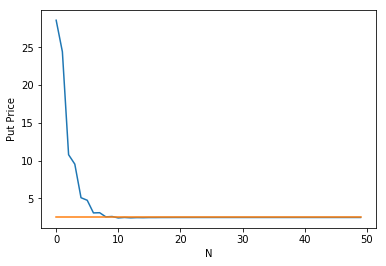

In [31]:
# plotting the results
plt.plot(COS_putprice)
plt.plot([analytic_putprice]*50)
plt.xlabel("N")
plt.ylabel("Put Price")
plt.show()

## 5. Use the fast Fourier transform (FFT) to price a European put option with the given parameters. 

You will have to price your put option for a range of strikes. Note that the only difference when applying the FFT to a put, when compared to a call, is that your value for α must be less than -1. 

Use a sequence length for your 

$x_n$ of N = 210


$\delta_u$ = 0.25. 

Plot the estimated put prices against the analytical put prices (across the range of strikes). (20% of total points)

In [32]:
# Algorithm info 
N = 210
delta = 0.25
alpha = -1.5

In [33]:
# evaluates the characterstic function of ST (log(ST))
def log_char(u):
    return np.exp(1j*u*(np.log(S0) + (r-sigma**2/2)*T)-sigma**2*T*u**2/2)

# determines c(hat)T(u)
def c_func(v):
    val1 = np.exp(-r*T)*log_char(v-(alpha+1)*1j)
    val2 = alpha**2+alpha-v**2+1j*(2*alpha+1)*v
    return val1/val2

In [34]:
# is the set [0, 1, ..., N-1]
n = np.array(range(N))

# is used to find b, the upper bound of the strike segmentation interval
delta_k = 2*np.pi/(N*delta)
b = delta_k*(N-1)/2

log_strike = np.linspace(-b,b,N)

In [36]:
x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
x[0] = x[0]*0.5
x[-1] = x[-1]*0.5

xhat = np.fft.fft(x).real

fft_put = np.exp(-alpha*log_strike)*xhat/np.pi

## Additional Questions

### 6.  Of the 3 methods, which is numerically the most accurate when near the money?
     (5% of total points)


The COS method is the most occurate when near the money, however, it has some issues for extreme moneyness.

### 7. Do the methods still work well when the option price is far from the money? ( Hint: Think of the volatility smile)
    (5% of total points)


They do not hold well as the Fourier methods look at the convergence of the estimates to the option price. Given that deep out of the money options is an example of extreme moneyness, these methods do not hold well.

### 8. Suppose the option had American exercise instead of European:

       a. Does the closed-form analytical Black-Scholes formula still work?
       b. Would a Fast Fourier Transform method still work?

     (5% of total points)



The closed form analytical model under Black-Scholes formula for American options would not work. The classic studied FFT woudl not work however a non-finite-difference-based method of American option pricing under stochastic volatility could work by extending the Geske-Johnson compound option scheme.

### 9. When would we use Monte Carlo simulation methods?
    (5% of total points)



It is used value and analyze (complex) instruments, portfolios and investments by simulating the various sources of uncertainty affecting their value, and then determining the distribution of their value over the range of resultant outcomes.

The advantage of Monte Carlo is its ability to factor in a range of values for various inputs; this is also its greatest disadvantage in the sense that assumptions need to be fair because the output is only as good as the inputs.

### 10. What is the best way to use Monte Carlo simulation on an exotic option?
     (5% of total points)



The best way to use Monte Carlo simulation on an exotic option is when there exists no closed-form solution to its pricing.